# Project 3 - Choose Your Own Adventure

Riley Galante

In [2]:
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
#fashion mnist dataset is already available in keras, easier to extract this way
from tensorflow.keras.datasets import fashion_mnist

housing = pd.read_csv("archive-3/WakeCountyHousing.csv")
((train_X, train_y), (test_X, test_y)) = fashion_mnist.load_data()

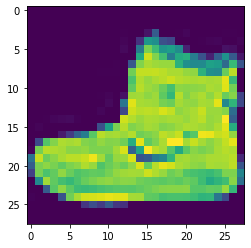

In [4]:
plt.imshow(train_X[0])

In [5]:
#check for missing data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308292 entries, 0 to 308291
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Real_Estate_Id      308292 non-null  int64  
 1   Deeded_Acreage      308292 non-null  float64
 2   Total_Sale_Price    308292 non-null  int64  
 3   Total_Sale_Date     308292 non-null  object 
 4   Month_Year_of_Sale  308292 non-null  object 
 5   Year_of_Sale        308292 non-null  int64  
 6   Year_Built          308292 non-null  int64  
 7   Year_Remodeled      308292 non-null  int64  
 8   Heated_Area         308292 non-null  int64  
 9   Num_Stories         308292 non-null  object 
 10  Design_Style        308292 non-null  object 
 11  Bath                308275 non-null  object 
 12  Utilities           306324 non-null  object 
 13  Physical_City       308183 non-null  object 
 14  Physical_Zip        308146 non-null  float64
dtypes: float64(2), int64(6), object(7)

In [6]:
#before any alterations are made to the data, separate housing data set 
#into training and testing set

#not really required but prevents data leaks and biases by only altering training set

from sklearn.model_selection import train_test_split

#separate dataset into predictor data and target data
house_target = housing.Total_Sale_Price
house_data = housing.loc[:, housing.columns != 'Total_Sale_Price'] #X

house_target = house_target.to_numpy()
house_data = house_data.to_numpy()

house_train_X, house_test_X, house_train_y, house_test_y = train_test_split(
    house_data, house_target, test_size = 0.3, random_state=None)

print(house_train_X.shape, house_test_X.shape)
print(house_train_y.shape, house_test_y.shape)



(215804, 14) (92488, 14)
(215804,) (92488,)


In [7]:
#recombine x train and y train into one dataframe

house_train_y = house_train_y.reshape(-1,1)
train = np.concatenate((house_train_X, house_train_y), axis=1)
housing = pd.DataFrame(train, columns=['Real_Estate_Id', 'Deeded_Acreage', 'Total_Sale_Date',
'Month_Year_of_Sale', 'Year_of_Sale', 'Year_Built', 'Year_Remodeled', 'Heated Area', 'Num_Stories',
'Design_Style', 'Bath', 'Utilities', 'Physical_City', 'Physical_Zip', 'Total_Sale_Price'])
housing.head()

,Real_Estate_Id,Deeded_Acreage,Total_Sale_Date,Month_Year_of_Sale,Year_of_Sale,Year_Built,Year_Remodeled,Heated Area,Num_Stories,Design_Style,Bath,Utilities,Physical_City,Physical_Zip,Total_Sale_Price
0,292573,0.07,4/30/2012,April 2012,2012,2002,2002,2269,Other,Townhouse,2½ Bath,ALL,Raleigh,27613.0,209000
1,267422,0.14,9/13/2006,September 2006,2006,2000,2000,2064,Other,Conventional,2½ Bath,ALL,Raleigh,27616.0,198000
2,323230,0.05,7/1/2020,July 2020,2020,2007,2007,1837,Two Story,Townhouse,2½ Bath,ALL,Raleigh,27606.0,277500
3,378045,0.23,6/13/2017,June 2017,2017,2010,2010,2343,Other,Conventional,2½ Bath,ALL,Holly Springs,27540.0,350000
4,358621,0.19,11/29/2016,November 2016,2016,2007,2007,1723,One Story,Conventional,2 Bath,ALL,Fuquay Varina,27526.0,218500


In [8]:
#lots of categorical variables in this dataset, bath, utilites, physical_city, and physical_zip
#all have missing values
#instead of deleting, inpute the most common occuring value for each of those categories

nan_columns = housing.columns[housing.isnull().any()]

for feature in nan_columns:
    common_val = housing[feature].value_counts().idxmax()
    print("null values in "+feature+" column will be inputed with "+str(common_val))
    housing[feature].fillna(common_val, inplace=True)

if(len(housing.columns[housing.isnull().any()]) == 0):
    print("No more null values")

null values in Bath column will be inputed with 2½ Bath
null values in Utilities column will be inputed with ALL
null values in Physical_City column will be inputed with Raleigh
null values in Physical_Zip column will be inputed with 27587.0
No more null values


In [9]:
#there are lots of features in this dataset that are categorical. These are the features
#that have an object datatype in the housing.info() above. They need to be encoded in a way
#the model can understand

#change total_sale_date strings into datetime
housing.Total_Sale_Date = pd.to_datetime(housing.Total_Sale_Date)

#month_year_of_sale is redundant information since we already have the datetime of the sale
#so it can be removed
del housing['Month_Year_of_Sale']

housing.head(10)

,Real_Estate_Id,Deeded_Acreage,Total_Sale_Date,Year_of_Sale,Year_Built,Year_Remodeled,Heated Area,Num_Stories,Design_Style,Bath,Utilities,Physical_City,Physical_Zip,Total_Sale_Price
0,292573,0.07,2012-04-30,2012,2002,2002,2269,Other,Townhouse,2½ Bath,ALL,Raleigh,27613.0,209000
1,267422,0.14,2006-09-13,2006,2000,2000,2064,Other,Conventional,2½ Bath,ALL,Raleigh,27616.0,198000
2,323230,0.05,2020-07-01,2020,2007,2007,1837,Two Story,Townhouse,2½ Bath,ALL,Raleigh,27606.0,277500
3,378045,0.23,2017-06-13,2017,2010,2010,2343,Other,Conventional,2½ Bath,ALL,Holly Springs,27540.0,350000
4,358621,0.19,2016-11-29,2016,2007,2007,1723,One Story,Conventional,2 Bath,ALL,Fuquay Varina,27526.0,218500
5,63506,0.32,1999-09-10,1999,1916,1916,2465,One Story,Conventional,3 Bath,ALL,Raleigh,27608.0,365000
6,423450,0.19,2019-01-04,2019,2016,2016,2831,Other,Conventional,2½ Bath,ALL,Holly Springs,27540.0,489000
7,413804,0.3,2014-07-29,2014,2014,2014,3085,Other,Conventional,3 Bath,E,Raleigh,27616.0,271000
8,136445,0.0,1995-06-13,1995,1984,1984,1136,One Story,Condo,2 Bath,ALL,Raleigh,27605.0,124500
9,143813,0.05,2018-07-16,2018,1985,1985,1625,One Story,Townhouse,2 Bath,ALL,Cary,27513.0,205500


In [10]:
#looking at the remaining categorical variables, a ranking system could potentially be generated
#for the bath and number of stories features, because generally a house with more of each
#will be more expensive
#thus, bath and number of stories will be ordinally encoded

#mapping strategy of ordinal encoding using category encoders was gathered from:
#https://leochoi146.medium.com/how-and-when-to-use-ordinal-encoder-d8b0ef90c28c
from category_encoders import OrdinalEncoder

#specify the ranking order for encoder. per documentation, other typically meant limited,
#adequate, or no plumbing at all, which I deemed would be ranked below having 1 functional bath
maplist = [{'col': 'Bath', 'mapping': {'Other': 0, '1 Bath': 1,'1 ½ Bath': 2,
 '2 Bath': 3, '2½ Bath': 4,'3 Bath': 5, '3½ Bath': 6}}]

enc = OrdinalEncoder(mapping=maplist)
housing = enc.fit_transform(housing)

#per documentation, other typically mean 3 or multi story houses, which rank above two stories
maplist = [{'col': 'Num_Stories', 'mapping': {'One Story': 0, 'Two Story': 1,'Other': 2}}]
enc = OrdinalEncoder(mapping=maplist)
housing = enc.fit_transform(housing)

None

In [11]:
housing[['Bath', 'Num_Stories']].head(10)


,Bath,Num_Stories
0,4,2
1,4,2
2,4,1
3,4,2
4,3,0
5,5,0
6,4,2
7,5,2
8,3,0
9,3,0


In [12]:
#Design_style, utilities, physical city are the remaining categorical variables
#these will be one hot encoded because they are nominal
#get_dummies is a way to one hot encode using pandas

#features to one hot encode
features_enc = ['Design_Style', 'Utilities', 'Physical_City']

#makes dataframe of the one hot encoded variables, concatenated together columnwise
one_hot_housing = pd.concat([pd.get_dummies(housing[col],prefix=col) for col in features_enc], axis=1)

#concatenate one hot encoded variables to housing dataframe
housing = pd.concat([housing, one_hot_housing], axis=1)

#remove columns that have been one hot encoded
del housing['Design_Style']
del housing['Utilities']
del housing['Physical_City']

housing.head(10)

,Real_Estate_Id,Deeded_Acreage,Total_Sale_Date,Year_of_Sale,Year_Built,Year_Remodeled,Heated Area,Num_Stories,Bath,Physical_Zip,...,Physical_City_Knightdale,Physical_City_Morrisville,Physical_City_New Hill,Physical_City_Raleigh,Physical_City_Rolesville,Physical_City_Wake Forest,Physical_City_Wendell,Physical_City_Willow Spring,Physical_City_Youngsville,Physical_City_Zebulon
0,292573,0.07,2012-04-30,2012,2002,2002,2269,2,4,27613.0,...,0,0,0,1,0,0,0,0,0,0
1,267422,0.14,2006-09-13,2006,2000,2000,2064,2,4,27616.0,...,0,0,0,1,0,0,0,0,0,0
2,323230,0.05,2020-07-01,2020,2007,2007,1837,1,4,27606.0,...,0,0,0,1,0,0,0,0,0,0
3,378045,0.23,2017-06-13,2017,2010,2010,2343,2,4,27540.0,...,0,0,0,0,0,0,0,0,0,0
4,358621,0.19,2016-11-29,2016,2007,2007,1723,0,3,27526.0,...,0,0,0,0,0,0,0,0,0,0
5,63506,0.32,1999-09-10,1999,1916,1916,2465,0,5,27608.0,...,0,0,0,1,0,0,0,0,0,0
6,423450,0.19,2019-01-04,2019,2016,2016,2831,2,4,27540.0,...,0,0,0,0,0,0,0,0,0,0
7,413804,0.3,2014-07-29,2014,2014,2014,3085,2,5,27616.0,...,0,0,0,1,0,0,0,0,0,0
8,136445,0.0,1995-06-13,1995,1984,1984,1136,0,3,27605.0,...,0,0,0,1,0,0,0,0,0,0
9,143813,0.05,2018-07-16,2018,1985,1985,1625,0,3,27513.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#zipcode is represented as a float, even as an int, the information is not
#particularly useful, since it is represented in one hot encoding by the physical city
#thus, zip code is redundant information and can be removed for cleanliness sake

del housing['Physical_Zip']

In [14]:
#for custom transformer, year built and year remodeled can be combined together into
#year last altered. while it matters when the house was built, its more important when
#the house was last remodeled, since the year remodeled column just includes year built
#if the house has not been remodeled, combining the two columns into one makes sense

from sklearn.base import BaseEstimator, TransformerMixin

class CombineAttributes(BaseEstimator, TransformerMixin):
    
    def __init__(self, year_last_alter):
        self.year_last_alter = year_last_alter

    def fit(self, X, y=None):
        return self

    #in this case, X is going to be a pandas df (housing), so its ok to assume
    #X is a dataframe
    #will go ahead and return modified dataframe
    def transform(self, X):
        for _, row in X.iterrows():
            if row['Year_Built'] == row['Year_Remodeled']:
                self.year_last_alter.append(row['Year_Built'])
            else:
                self.year_last_alter.append(row['Year_Remodeled'])
        
        new_df = pd.DataFrame(self.year_last_alter, columns=['Year_Last_Altered'])
        new_df = pd.concat([X, new_df], axis=1)

        #remove year built and year remodeled from new df since its been combined
        del new_df['Year_Built']
        del new_df['Year_Remodeled']

        return new_df


transformer = CombineAttributes(year_last_alter=[])
new_housing = transformer.transform(housing)
new_housing.head(35)



,Real_Estate_Id,Deeded_Acreage,Total_Sale_Date,Year_of_Sale,Heated Area,Num_Stories,Bath,Total_Sale_Price,Design_Style_Cape,Design_Style_Colonial,...,Physical_City_Morrisville,Physical_City_New Hill,Physical_City_Raleigh,Physical_City_Rolesville,Physical_City_Wake Forest,Physical_City_Wendell,Physical_City_Willow Spring,Physical_City_Youngsville,Physical_City_Zebulon,Year_Last_Altered
0,292573,0.07,2012-04-30,2012,2269,2,4,209000,0,0,...,0,0,1,0,0,0,0,0,0,2002
1,267422,0.14,2006-09-13,2006,2064,2,4,198000,0,0,...,0,0,1,0,0,0,0,0,0,2000
2,323230,0.05,2020-07-01,2020,1837,1,4,277500,0,0,...,0,0,1,0,0,0,0,0,0,2007
3,378045,0.23,2017-06-13,2017,2343,2,4,350000,0,0,...,0,0,0,0,0,0,0,0,0,2010
4,358621,0.19,2016-11-29,2016,1723,0,3,218500,0,0,...,0,0,0,0,0,0,0,0,0,2007
5,63506,0.32,1999-09-10,1999,2465,0,5,365000,0,0,...,0,0,1,0,0,0,0,0,0,1916
6,423450,0.19,2019-01-04,2019,2831,2,4,489000,0,0,...,0,0,0,0,0,0,0,0,0,2016
7,413804,0.3,2014-07-29,2014,3085,2,5,271000,0,0,...,0,0,1,0,0,0,0,0,0,2014
8,136445,0.0,1995-06-13,1995,1136,0,3,124500,0,0,...,0,0,1,0,0,0,0,0,0,1984
9,143813,0.05,2018-07-16,2018,1625,0,3,205500,0,0,...,0,0,0,0,0,0,0,0,0,1985


In [15]:
#use standard scaler for standardization on housing dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#do not need to standardize target
housing_X = new_housing.drop('Total_Sale_Price', axis=1)

#omit total sale date because it is a datetime and cannot be scaled. year of sale is already
#in the dataset and should suffice as a subsitute
housing_scaled = scaler.fit_transform(housing_X.loc[:, housing_X.columns != 'Total_Sale_Date'])
housing_scaled = pd.DataFrame(housing_scaled, columns=[x for x in housing_X.columns if x!='Total_Sale_Date'])


In [16]:
housing_scaled.head()

,Real_Estate_Id,Deeded_Acreage,Year_of_Sale,Heated Area,Num_Stories,Bath,Design_Style_Cape,Design_Style_Colonial,Design_Style_Condo,Design_Style_Contemporary,...,Physical_City_Morrisville,Physical_City_New Hill,Physical_City_Raleigh,Physical_City_Rolesville,Physical_City_Wake Forest,Physical_City_Wendell,Physical_City_Willow Spring,Physical_City_Youngsville,Physical_City_Zebulon,Year_Last_Altered
0,0.371326,-0.190096,0.231480,0.004208,0.778725,0.081776,-0.004813,-0.010324,-0.200961,-0.045508,...,-0.156124,-0.057372,1.066556,-0.093519,-0.268752,-0.135291,-0.088151,-0.02339,-0.116995,0.320021
1,0.177688,-0.154674,-0.338434,-0.201900,0.778725,0.081776,-0.004813,-0.010324,-0.200961,-0.045508,...,-0.156124,-0.057372,1.066556,-0.093519,-0.268752,-0.135291,-0.088151,-0.02339,-0.116995,0.217359
2,0.607354,-0.200217,0.991366,-0.430126,-0.309032,0.081776,-0.004813,-0.010324,-0.200961,-0.045508,...,-0.156124,-0.057372,1.066556,-0.093519,-0.268752,-0.135291,-0.088151,-0.02339,-0.116995,0.576676
3,1.029374,-0.109131,0.706409,0.078607,0.778725,0.081776,-0.004813,-0.010324,-0.200961,-0.045508,...,-0.156124,-0.057372,-0.937598,-0.093519,-0.268752,-0.135291,-0.088151,-0.02339,-0.116995,0.730669
4,0.879829,-0.129372,0.611423,-0.544742,-1.396789,-0.589238,-0.004813,-0.010324,-0.200961,-0.045508,...,-0.156124,-0.057372,-0.937598,-0.093519,-0.268752,-0.135291,-0.088151,-0.02339,-0.116995,0.576676


In [17]:
#Linear Regression on housing
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_scaled, new_housing.Total_Sale_Price)

LinearRegression()

In [18]:
from sklearn.metrics import explained_variance_score as ev_score

ev_score(new_housing.Total_Sale_Price, lin_reg.predict(housing_scaled))

0.6966839256285773

1.0 is best, so ~0.7 in explained variance score means that the linear regression model does not best model the data.

In [19]:
from sklearn.metrics import mean_squared_error as mse

mse(new_housing.Total_Sale_Price, lin_reg.predict(housing_scaled), squared=False)

104563.65359187337

Root mean squared error is large, so linear regression is not the best to model this data.

In [20]:
from sklearn.tree import DecisionTreeRegressor

tr_reg = DecisionTreeRegressor()
tr_reg.fit(housing_scaled, new_housing.Total_Sale_Price)

DecisionTreeRegressor()

In [21]:
ev_score(new_housing.Total_Sale_Price, tr_reg.predict(housing_scaled))

1.0

In [22]:
mse(new_housing.Total_Sale_Price, tr_reg.predict(housing_scaled), squared=False)

0.0

EV score and RMSE are perfect, most likely meaning an overfitting of data. This can be checked through k-fold cross validation

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tr_reg, housing_scaled, new_housing.Total_Sale_Price,
    scoring="neg_mean_squared_error", cv=10)
#root for RMSE, take negative of scores because cross_val expects utility function (to be maximized)
#instead of a cost function (to be minimized)
tree_scores = np.sqrt(-scores)
print("Mean: ", tree_scores.mean())
print("Standard Deviation: ", tree_scores.std())

Mean:  108888.36908629425
Standard Deviation:  5909.07690047897


Cross val using validation sets shows that this model actually does not perform well, and just overfits the training data given.

In [25]:
#since housing price does not necessarily have a linear correlation with the features,
#random forest regressor might the most effective regression to use

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(housing_scaled, new_housing.Total_Sale_Price)

RandomForestRegressor()

In [26]:
#test fit
print("EV Score: ", ev_score(new_housing.Total_Sale_Price, forest.predict(housing_scaled)))

cv_scores = cross_val_score(forest, housing_scaled, new_housing.Total_Sale_Price,
    scoring="neg_mean_squared_error", cv=3)
#root for RMSE, take negative of scores because cross_val expects utility function (to be maximized)
#instead of a cost function (to be minimized)
forest_scores = np.sqrt(-cv_scores)
print("Mean: ", forest_scores.mean())
print("Standard Deviation: ", forest_scores.std())

EV Score:  0.975775169883646
Mean:  80118.4056058066
Standard Deviation:  2458.9344834085337


In [27]:
#this model appears to perform better than the linear and decision tree models
#use grid cv to tune hyperparameters

#adapted from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import GridSearchCV

bootstrap = [True, False]
n_estimators = [10, 20, 40]
max_depth = [40, 80, 100]
max_features = [2, 4, 6, 8, 10]
min_samples_leaf = [3, 4, 5]
min_samples_split = [6, 8, 10]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

forest_search = GridSearchCV(forest, param_grid, cv=3, n_jobs=-1, verbose=1)
forest_search.fit(housing_scaled, new_housing.Total_Sale_Price)
forest_search.best_params_

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


{'bootstrap': False,
 'max_depth': 100,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 40}

In [29]:
#test hypertuned fit
print("EV Score: ", ev_score(new_housing.Total_Sale_Price, forest_search.best_estimator_.predict(housing_scaled)))

cv_scores = cross_val_score(forest_search.best_estimator_, housing_scaled, new_housing.Total_Sale_Price,
    scoring="neg_mean_squared_error", cv=3)
#root for RMSE, take negative of scores because cross_val expects utility function (to be maximized)
#instead of a cost function (to be minimized)
forest_sr_scores = np.sqrt(-cv_scores)
print("Mean: ", forest_sr_scores.mean())
print("Standard Deviation: ", forest_sr_scores.std())

EV Score:  0.9248567971199093
Mean:  78708.97615099188
Standard Deviation:  2346.3329888691046


Using cross validation on the hypertuned model, the rmse and standard deviation are lower, which is good! The ev score did lower, but because it was not tested using cross val, it is not as indicative of the performance of the model

This model won't be tested on the test set in this project, but the hypertuned model would be used with the prepared X test set to predict housing prices in the test y set.

In [45]:
#all data from keras fashion mnist is pretty much ready to rock
#normalize and one hot encode target

train_X = train_X / 255.0
test_X = test_X / 255.0

#reshape from 3D to 2D
nsamples, nx, ny = train_X.shape
train_X = train_X.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_X.shape
test_X = test_X.reshape((nsamples,nx*ny))

print(train_X.shape, train_y.shape)
print(train_y[0])

(60000, 784) (60000,)
9


In [46]:
#SGD Classifier

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

sgd_clf = SGDClassifier()
sgd_clf.fit(train_X, train_y)
accuracy_score(train_y, sgd_clf.predict(train_X))


0.8513

In [47]:
#Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(train_X, train_y)
accuracy_score(train_y, forest_clf.predict(train_X))

1.0

In [51]:
#Test with stratified kfold
#structure taken from chapter 3 of textbook

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(train_X, train_y):
    clone_clf = clone(forest_clf)
    X_train_folds = train_X[train_index]
    y_train_folds = train_y[train_index]
    X_test_fold = train_X[test_index]
    y_test_fold = train_y[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  

0.87725
0.8806
0.88175


In [48]:
#Neighbors Classifier

from sklearn.neighbors import KNeighborsClassifier

neighbors_clf = KNeighborsClassifier()
neighbors_clf.fit(train_X, train_y)
accuracy_score(train_y, neighbors_clf.predict(train_X))

0.8997666666666667

In [ ]:
train_y_0 = (train_y == 0)

In [60]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

neighbors_clf_2 = KNeighborsClassifier()
neighbors_clf_2.fit(train_X, train_y_0)
y_train_pred = cross_val_predict(neighbors_clf_2, train_X, train_y_0, cv=3)

confusion_matrix(train_y_0, y_train_pred)

array([[52769,  1231],
       [  991,  5009]])

The above is the confusion matrix. It represents the classification of true negative, false positive, false negative, and true positives for a class. It can be useful to visualize the true and false classifications for the classes. For class 0, there were 52,769 correct negative classifications, and 5,009 images that were correctly classified as class 0

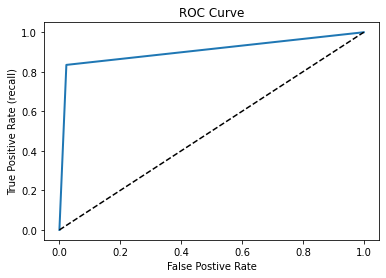

0.9060185185185186

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(train_y_0, y_train_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate (recall)')
    plt.title('ROC Curve')

plot_roc_curve(fpr, tpr)
plt.show()

roc_auc_score(train_y_0, y_train_pred)

In [50]:
#OvR Classifier

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(neighbors_clf).fit(train_X, train_y)
ovr_clf.score(train_X, train_y)


0.8977166666666667

In [64]:
#ensemble of methods

from sklearn.ensemble import VotingClassifier

model_1 = SGDClassifier()
model_2 = RandomForestClassifier()
model_3 = KNeighborsClassifier()

#voting classifier with hard voting will classify based on majority rule of each
#individual classifier

final_model = VotingClassifier(
    estimators=[('sgd', model_1),
    ('r_forest', model_2),
    ('k_neighbors', model_3)], voting='hard'
)

final_model.fit(train_X, train_y)

#test this model on test set
accuracy_score(test_y, final_model.predict(test_X))


0.8778

The final classifier got an 87% accuracy score, which isn't too bad for fashion mnist. An improvement would be to use neural networks

In [68]:
((train_X, train_y), (test_X, test_y)) = fashion_mnist.load_data()

class Preprocess(BaseEstimator, TransformerMixin):
    
    def __init__(self, train_X, test_X):
        self.train_X = train_X
        self.test_X = test_X

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.train_X = X / 255.0
        self.test_X = X / 255.0

        #reshape from 3D to 2D
        nsamples, nx, ny = self.train_X.shape
        self.train_X = self.train_X.reshape((nsamples,nx*ny))

        nsamples, nx, ny = self.test_X.shape
        self.test_X = self.test_X.reshape((nsamples,nx*ny))

        return train_X, test_X

#pipeline

from sklearn.pipeline import Pipeline

pipe =  Pipeline([
    ('pre', Preprocess(train_X = train_X, test_X = test_X))
    ('model', VotingClassifier(estimators=[('sgd', model_1),
        ('r_forest', model_2),
        ('k_neighbors', model_3)], voting='hard'))
])

pipe.fit(train_X, train_y)
accuracy_score(test_y, pipe.predict(test_y))


<>:30: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:30: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/var/folders/fw/yhp943js3txfhj0pl7bt4xr80000gn/T/ipykernel_62303/2490139435.py:30: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('pre', Preprocess(train_X = train_X, test_X = test_X))


TypeError: 'tuple' object is not callable